In [277]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [278]:
df = pd.read_parquet(r"../data/types_fixed_german_credit_data.parquet", engine="pyarrow")

I will not select **Duration** due to it's correlation with credit amount.

In [279]:
selected_features = [
    "Credit amount",
    "Purpose",
    "Job",
    "Sex",
    "Saving accounts",
    "Housing",
    "Risk",
    "Age",
    "Unnamed: 0"  # this column contains indexes for duplicated data
]

df = df[selected_features]
df["Job"] = df["Job"].astype("Int64")  # don't know why Job is being picked up as float
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Credit amount    4568 non-null   Int64   
 1   Purpose          4686 non-null   category
 2   Job              4635 non-null   Int64   
 3   Sex              4617 non-null   category
 4   Saving accounts  3306 non-null   category
 5   Housing          4622 non-null   category
 6   Risk             4705 non-null   category
 7   Age              4703 non-null   Int64   
 8   Unnamed: 0       4685 non-null   float64 
dtypes: Int64(3), category(5), float64(1)
memory usage: 190.4 KB


Got to drop all rows where Risk is NAN. To stratify latter target var can not have missing values.

In [280]:
df = df.dropna(subset=["Risk"])

In [281]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4705 entries, 0 to 4845
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Credit amount    4488 non-null   Int64   
 1   Purpose          4625 non-null   category
 2   Job              4513 non-null   Int64   
 3   Sex              4502 non-null   category
 4   Saving accounts  3221 non-null   category
 5   Housing          4507 non-null   category
 6   Risk             4705 non-null   category
 7   Age              4576 non-null   Int64   
 8   Unnamed: 0       4573 non-null   float64 
dtypes: Int64(3), category(5), float64(1)
memory usage: 221.5 KB


As encountered in the previous EDA, housing, sex and purpose features had some weird, probably tampered, values in them, let's ditch those.

In [282]:
weird_categories = {
    "Housing" : ["356", "43", "563"],
    "Sex" : ["353546"],
    "Purpose" : ["3", "356", "56", "6"]
}

for col, values in weird_categories.items():
    df[col] = df[col].replace(values, np.nan)

In [283]:
df.isna().sum()

Credit amount       217
Purpose              85
Job                 192
Sex                 206
Saving accounts    1484
Housing             205
Risk                  0
Age                 129
Unnamed: 0          132
dtype: int64

Now let's remove all duplicated values

In [284]:
df = df.drop_duplicates(subset=["Unnamed: 0"])
df.drop(columns=["Unnamed: 0"], inplace= True)

In [285]:
num_cols = ["Credit amount", "Age"]
cat_cols = ["Purpose", "Housing", "Sex"]
cat_ord_cols = ["Saving accounts", "Job"]

In [286]:
def outliers_feature_names(_, feature_names) -> np.ndarray:
    return feature_names

def remove_outliers(X: pd.DataFrame, threshold: float = 1.5) -> pd.DataFrame:
    """
    Replace outliers from numeric columns given a certain treshold with NAN.
    Args:
        threshold (float, optional): Treshold for removing minor (1.5) or extreme outliers (3.0). Defaults to 1.5.
    """
    assert isinstance(X, pd.DataFrame)
    assert 1.5 <= threshold <= 3.0
    Q1, Q3 = X.quantile(0.25), X.quantile(0.75)
    IQR: float = Q3 - Q1
    mask: function = ~((X >= (Q1 - threshold * IQR)) & (X <= (Q3 + threshold * IQR))).all(axis=1)
    X.loc[mask] = np.nan
    return X

In [287]:
numeric_pipe = Pipeline(
    steps=[
        ("outlier removal", FunctionTransformer(
            remove_outliers,
            kw_args={'threshold': 3.0}, 
            feature_names_out=outliers_feature_names
        )),
        ("imputer", KNNImputer(n_neighbors=5))
    ]
)

cat_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(drop="first"))
    ]
)

cat_ord_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OrdinalEncoder())
    ]
)

ordinal_transformers = [(f"{col}_ordinal", cat_ord_pipe, [col]) for col in cat_ord_cols]


preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipe, num_cols),
        ("categoric", cat_pipe, cat_cols),
    ] + ordinal_transformers
)

In [288]:
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('outlier removal',
                                                  FunctionTransformer(feature_names_out=<function outliers_feature_names at 0x000002D1C2C85580>,
                                                                      func=<function remove_outliers at 0x000002D1C2C85800>,
                                                                      kw_args={'threshold': 3.0})),
                                                 ('imputer', KNNImputer())]),
                                 ['Credit amount', 'Age']),
                                ('categoric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImpute..._frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first'))]),
                                 ['Purpose', 'Housing', 'Sex']),
                                ('Saving accounts_ordinal',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot', OrdinalEncoder())]),
                                 ['Saving accounts']),
                                ('Job_ordinal',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot', OrdinalEncoder())]),
                                 ['Job'])])

**Pipeline description**
1. Numeric Pipeline:
   - Columns: Credit amount, Age.
   - Steps:
     - FunctionTransformer(outlier_removal): Replaces with NAN detected outliers with the IQR method.
     - KNNImputer(n_neighbors=5): Imputes missing values using KNN model approach.
2. Categorical Pipeline:
   - Columns: Purpose, Housing, Sex.
   - Steps:
     - SimpleImputer(strategy="most_frequent"): Imputes missing values using the most frequent value in each column.
     - OneHotEncoder(drop='first'): Encodes categorical features as a one-hot numeric array droping onw of the columns for preventing multicollinearity.
3. Categorical Ordinal Pipeline:
   - Columns: Saving accounts, Job.
   - Steps:
     - SimpleImputer(strategy="most_frequent"): Imputes missing values using the most frequent value in each column.
     - OrdinalEncoder(): Encodes categorical features as ordinal integers.
4. Column Transformer:
   - Combines the numeric, categorical, and categorical ordinal pipelines into a single preprocessing step.

In [289]:
X_features = df.drop(columns=["Risk"])
Y_target = df["Risk"]#.map({"good": 1, "bad": 0})

x_train, x_test, y_train, y_test = train_test_split(
    X_features, Y_target, test_size=0.2, stratify= Y_target
)

In [290]:
preprocessed_data = preprocessor.fit(x_train)
feature_names = preprocessor.get_feature_names_out()
x_train_preprocessed = preprocessor.fit_transform(x_train)
x_train_preprocessed = pd.DataFrame(x_train_preprocessed, columns= feature_names)

In [291]:
x_train_preprocessed.head()

,numeric__Credit amount,numeric__Age,categoric__Purpose_car,categoric__Purpose_domestic appliances,categoric__Purpose_education,categoric__Purpose_furniture/equipment,categoric__Purpose_radio/TV,categoric__Purpose_repairs,categoric__Purpose_vacation/others,categoric__Housing_own,categoric__Housing_rent,categoric__Sex_male,Saving accounts_ordinal__Saving accounts,Job_ordinal__Job
0,1107.0,20.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0
1,1200.0,23.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0
2,2751.0,38.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0
3,1282.0,32.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,2439.0,35.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0


In [292]:
x_train.head()

,Credit amount,Purpose,Job,Sex,Saving accounts,Housing,Age
313,1107,radio/TV,3,male,little,rent,20
272,1200,education,2,female,NaN,rent,23
1600,2751,car,2,male,NaN,own,38
31,1282,radio/TV,1,female,NaN,own,32
909,2439,radio/TV,2,female,little,own,35


In [293]:
values_to_remove = [-456789, 987875643454698, 65445678765, 25364435423, 76543456, 987657]  # let's remove some gross outliers
x_train = x_train[~x_train["Credit amount"].isin(values_to_remove)] 

Finally, I'd like to compare the post processed numeric features distributions with the base numerical features distributions to determine whether imputation is working fine or not.

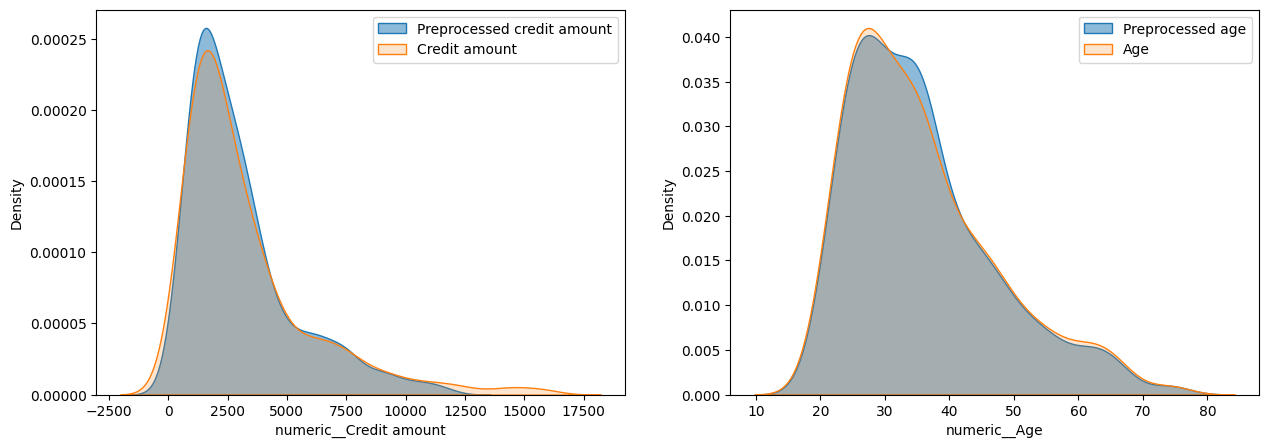

In [294]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sns.kdeplot(data = x_train_preprocessed["numeric__Credit amount"], label = "Preprocessed credit amount", fill = True, alpha = 0.5, ax=ax1)
sns.kdeplot(data = x_train["Credit amount"], label = "Credit amount", fill = True, alpha = 0.2, ax=ax1)
ax1.legend()

sns.kdeplot(data = x_train_preprocessed["numeric__Age"], label = "Preprocessed age", fill = True, alpha = 0.5, ax=ax2)
sns.kdeplot(data = x_train["Age"], label = "Age", fill = True, alpha = 0.2, ax=ax2)
ax2.legend()

plt.show()

**Final recommendations and Ideas**
1. Feature Scaling: Add a scaling step to the numeric pipeline using StandardScaler or MinMaxScaler.
   - Rationale: Scaling numeric features can improve the performance of many machine learning algorithms by ensuring that all features contribute equally to the model.
2. Dive deeper on how to determine the optimal KNN imputer neighboors number.
   - Rationale: Determine the optimal neighboors number could provide better estimates for missing values.